Analysis for Dataset 1:

- [www.bbci.de/competition/iv/desc_1.html](https://www.bbci.de/competition/iv/desc_1.html)

In [ ]:
import os
import numpy as np
import scipy.io as sio
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import sklearn.utils.validation
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.base.blocks import InputToNode, NodeToNode

## Data exploration

In [2]:
BASE_DIR = 'data'
DATA_DIR = os.path.join(BASE_DIR, 'BCICIV_1_mat')
LABELS_DIR = os.path.join(BASE_DIR, 'true_labels')

print(f"Base dir: {BASE_DIR}")
print(f"Signal dir: {DATA_DIR}")
print(f"Labels dir: {LABELS_DIR}")

subject = 'g' # patient a, b, c, d, e, f, g

calib_file = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{subject}.mat')
eval_file = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{subject}.mat')
labels_file = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{subject}_1000Hz_true_y.mat')

Base dir: data
Signal dir: data/BCICIV_1_mat
Labels dir: data/true_labels


In [3]:
def inspect_mat_file(filepath, description):
    print()
    print(f"[{description}]")
    print(f"Path: {filepath}")
    
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return None

    try:
        mat = sio.loadmat(filepath)
    except Exception as e:
        print(f"Error loading .mat file: {e}")
        return None
    
    keys = [key for key in mat.keys() if not key.startswith('__')]
    print(f"Keys: {keys}")
    
    for key in keys:
        val = mat[key]
        
        # Continuous Signal
        if key == 'cnt':
            print(f" - '{key}': EEG Signal | Samples: {val.shape[0]} | Channels: {val.shape[1]} | Type: {val.dtype}")
        
        # Frequency Info
        elif key == 'nfo':
            try:
                fs = val[0,0]['fs'][0,0]
                classes = val[0,0]['classes']
                print(f" - '{key}': Sampling Rate: {fs} Hz | Classes: {classes}")
            except:
                print(f" - '{key}': Info structure detected")

        # Markers
        elif key == 'mrk':
            try:
                pos = val[0,0]['pos']
                y = val[0,0]['y']
                print(f" - '{key}': Markers | Count: {pos.shape[0] if len(pos.shape)>0 else 0} | Unique classes: {np.unique(y)}")
            except:
                print(f" - '{key}': Marker structure detected")
        
        # True Test Labels
        elif key == 'true_y':
            print(f" - '{key}': True Labels | Shape: {val.shape}")

    return mat


# Calibration Data
mat_calib = inspect_mat_file(calib_file, "Calibration Data")

# Evaluation Data (Signal)
mat_eval = inspect_mat_file(eval_file, "Evaluation Data")

# True Test Labels
mat_labels = inspect_mat_file(labels_file, "True Test Labels")


[Calibration Data]
Path: data/BCICIV_1_mat/BCICIV_calib_ds1g.mat
Keys: ['mrk', 'cnt', 'nfo']
 - 'mrk': Markers | Count: 1 | Unique classes: [-1  1]
 - 'cnt': EEG Signal | Samples: 190602 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[Evaluation Data]
Path: data/BCICIV_1_mat/BCICIV_eval_ds1g.mat
Keys: ['cnt', 'nfo']
 - 'cnt': EEG Signal | Samples: 243502 | Channels: 59 | Type: int16
 - 'nfo': Sampling Rate: 100 Hz | Classes: [[array(['left'], dtype='<U4') array(['right'], dtype='<U5')]]

[True Test Labels]
Path: data/true_labels/BCICIV_eval_ds1g_1000Hz_true_y.mat
Keys: ['true_y']
 - 'true_y': True Labels | Shape: (2435020, 1)


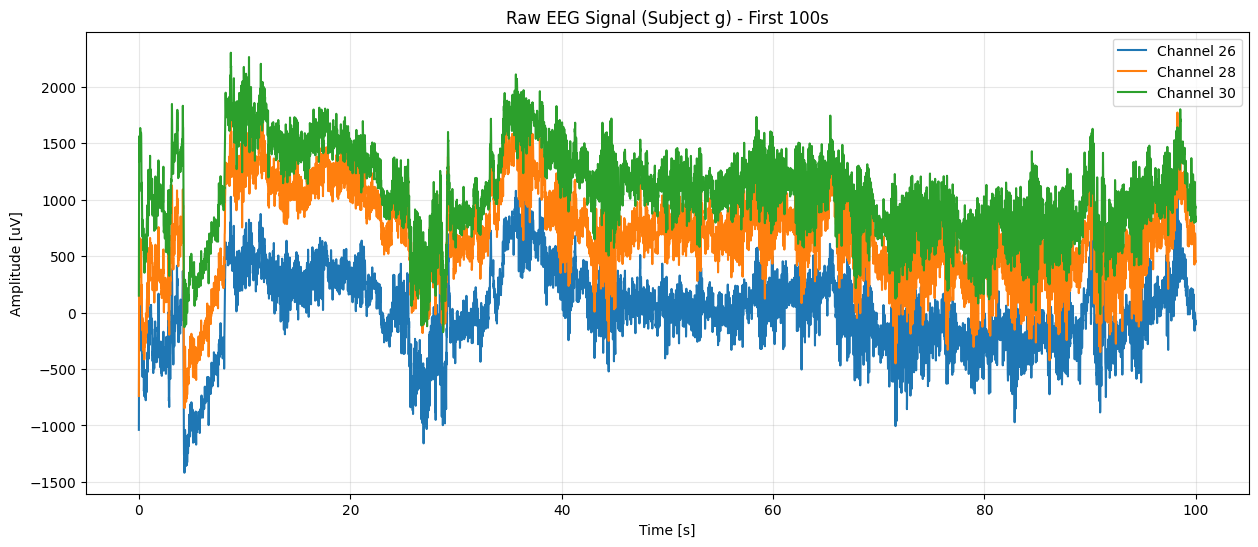

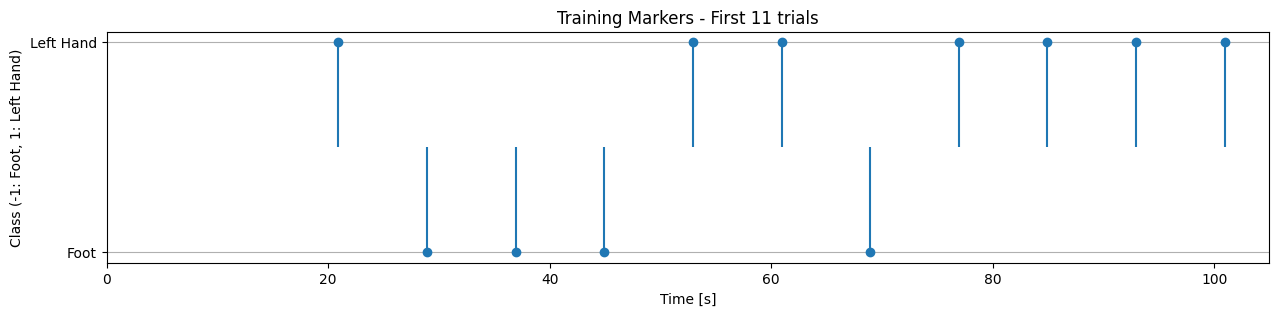

In [4]:
fs = 100  # Sampling frequency 100Hz

# Raw EEG Signal (first n seconds)
channels_to_plot = [26, 28, 30]
duration_sec = 100
samples_to_plot = duration_sec * fs

time_axis = np.arange(samples_to_plot) / fs
plt.figure(figsize=(15, 6))

for i, ch in enumerate(channels_to_plot):
    plt.plot(time_axis, mat_calib['cnt'][:samples_to_plot, ch] - np.mean(mat_calib['cnt'][:, ch]) + i*500, label=f'Channel {ch}')

plt.title(f'Raw EEG Signal (Subject {subject}) - First {duration_sec}s')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [uV]')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# Training Markers, when the patient was imagining movement
# 'pos' are indices where cues happened
train_pos = mat_calib['mrk'][0,0]['pos'].flatten()
train_y = mat_calib['mrk'][0,0]['y'].flatten()
limit = 11
plt.figure(figsize=(15, 3))
plt.stem(train_pos[:limit] / fs, train_y[:limit], basefmt=" ")
plt.title(f'Training Markers - First {limit} trials')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1: Foot, 1: Left Hand)')
plt.yticks([-1, 1], ['Foot', 'Left Hand'])
plt.grid(True, axis='y')
plt.xlim(0)
plt.show()

## Define data loading and target creation functions


- load_bci_data: Loads .mat files and downsamples labels
- create_continuous_target: Converts markers into continuous time-series signal. Assuming that the movement imagination takes 4 seconds.

In [5]:
def load_bci_data(subject):
    f_calib = os.path.join(DATA_DIR, f'BCICIV_calib_ds1{subject}.mat')
    f_eval = os.path.join(DATA_DIR, f'BCICIV_eval_ds1{subject}.mat')
    f_labels = os.path.join(LABELS_DIR, f'BCICIV_eval_ds1{subject}_1000Hz_true_y.mat')
    
    mat_calib = sio.loadmat(f_calib)
    X_train_raw = mat_calib['cnt'].astype(np.float64) 
    mrk_pos = mat_calib['mrk'][0,0]['pos'].flatten()
    mrk_y = mat_calib['mrk'][0,0]['y'].flatten()
    fs = mat_calib['nfo'][0,0]['fs'][0,0]
    
    mat_eval = sio.loadmat(f_eval)
    X_test_raw = mat_eval['cnt'].astype(np.float64)
    
    mat_labels = sio.loadmat(f_labels)
    y_test_1000hz = mat_labels['true_y'].flatten()
    
    y_test = y_test_1000hz[::10]
    
    min_len = min(len(X_test_raw), len(y_test))
    X_test_raw = X_test_raw[:min_len]
    y_test = y_test[:min_len]
    
    print(f"Subject {subject}: Data loaded.")
    print(f"X_train shape: {X_train_raw.shape}")
    print(f"X_test shape: {X_test_raw.shape}")
    
    return X_train_raw, mrk_pos, mrk_y, X_test_raw, y_test, fs


def create_continuous_target(n_samples, pos, y, fs, duration_sec=4.0):
    target = np.zeros(n_samples)
    duration_samples = int(duration_sec * fs)
    
    for p, label in zip(pos, y):
        end = min(p + duration_samples, n_samples)
        target[p:end] = label
        
    return target

- Continuous target creation - example

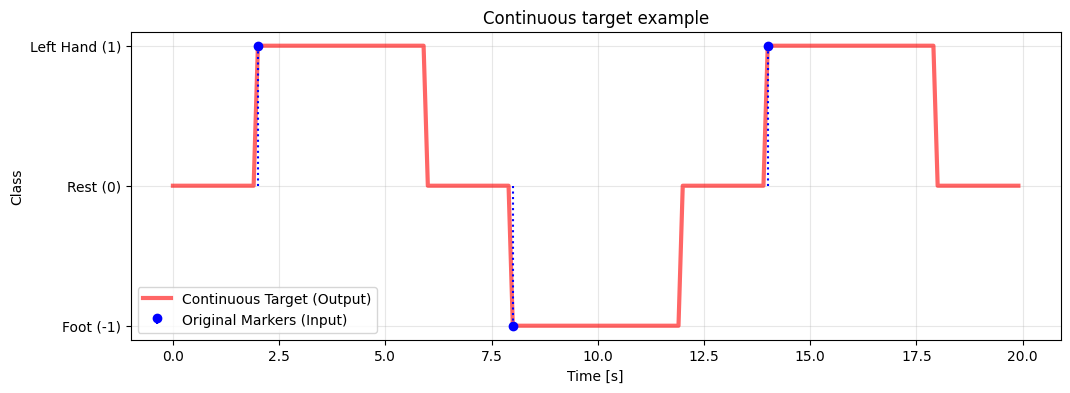

In [6]:
fs_example = 10
duration_total_sec = 20
n_samples_example = duration_total_sec * fs_example
pos_example = np.array([20, 80, 140])
y_example = np.array([1, -1, 1])

target_continuous_example = create_continuous_target(
    n_samples=n_samples_example, 
    pos=pos_example, 
    y=y_example, 
    fs=fs_example, 
    duration_sec=4.0 # assuming that each movement imagination lasts 4 seconds
)

time_axis_example = np.arange(n_samples_example) / fs_example
plt.figure(figsize=(12, 4))
plt.plot(time_axis_example, target_continuous_example, 'r-', linewidth=3, alpha=0.6, label='Continuous Target (Output)')
plt.stem(pos_example / fs_example, y_example, linefmt='b:', markerfmt='bo', basefmt=" ", label='Original Markers (Input)')
plt.title("Continuous target example")
plt.xlabel("Time [s]")
plt.ylabel("Class")
plt.yticks([-1, 0, 1], ['Foot (-1)', 'Rest (0)', 'Left Hand (1)'])
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Define signal processing functions

- preprocess_signal: Bandpass filtering (8-30Hz)
- extract_log_variance_features: Moving window log-variance extraction

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs # Nyquist freq - max possible freq to save when sampling fs (50% of fs according to Shannona theorem)
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')

    # filter coeffs - numerator b and denominator a polynomials
    return b, a


def preprocess_signal(data, lowcut=8.0, highcut=30.0, fs=100.0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=4)
    # Filtering with zero phase shift
    # filtering from left to right, and then from right to left
    y = filtfilt(b, a, data, axis=0)
    return y


def extract_log_variance_features(data, window_size=100):
    # changing volts to energy
    power = np.square(data) # temp energy approx
    window = np.ones(window_size) / window_size
    
    # smoothing energy using moving average to extract power trend
    feat_list = []
    for i in range(data.shape[1]):
        smooth_power = np.convolve(power[:, i], window, mode='same')
        feat_list.append(smooth_power)
        
    features = np.column_stack(feat_list)
    return np.log(features + 1e-6) # converting skewed distr to Gaussian

## Execute data loading and processing pipeline

- Load data for patient (subject)
- Clean NaNs from raw data
- Apply bandpass filter and feature extraction
- Clean NaNs from extracted features

In [8]:
X_train_raw, pos, y_class, X_test_raw, y_test, fs = load_bci_data(subject)

X_train_raw = np.nan_to_num(X_train_raw, nan=0.0, posinf=0.0, neginf=0.0)
X_test_raw = np.nan_to_num(X_test_raw, nan=0.0, posinf=0.0, neginf=0.0)

y_train = create_continuous_target(len(X_train_raw), pos, y_class, fs, duration_sec=4.0)

X_train_proc = preprocess_signal(X_train_raw, fs=fs)
X_test_proc = preprocess_signal(X_test_raw, fs=fs)

X_train_feats = extract_log_variance_features(X_train_proc, window_size=100)
X_test_feats = extract_log_variance_features(X_test_proc, window_size=100)

X_train_feats = np.nan_to_num(X_train_feats, nan=0.0, posinf=0.0, neginf=0.0)
X_test_feats = np.nan_to_num(X_test_feats, nan=0.0, posinf=0.0, neginf=0.0)

n_features = X_train_feats.shape[1]
print(f"Input shape: {X_train_feats.shape}")

Subject g: Data loaded.
X_train shape: (190602, 59)
X_test shape: (243502, 59)
Input shape: (190602, 59)


## Initialize and Train ESN Model

- Manually generate input weights
- Define ESN layers (Input, Reservoir with leakage, Readout)
- Train the model

In [9]:
hidden_size = 500 # TODO: experiment with bigger hidden size
k_in = 10 

rng = np.random.RandomState(0)
W_in = np.zeros((n_features, hidden_size))

for j in range(hidden_size):
    indices = rng.choice(n_features, k_in, replace=False)
    weights = rng.uniform(-0.1, 0.1, k_in)
    W_in[indices, j] = weights

input_to_node = InputToNode(
    hidden_layer_size=hidden_size,
    input_activation='identity',
    predefined_input_weights=W_in,
    bias_scaling=0.0
)

node_to_node = NodeToNode(
    hidden_layer_size=hidden_size,
    spectral_radius=0.9,
    leakage=0.1,
    reservoir_activation='tanh',
    bidirectional=False
)

regressor = Ridge(alpha=1e-3)

esn = ESNRegressor(
    input_to_node=input_to_node,
    node_to_node=node_to_node,
    regressor=regressor
)

esn.fit(X_train_feats, y_train)

ESNRegressor(input_to_node=InputToNode(bias_scaling=0.0,
                                       input_activation='identity',
                                       predefined_input_weights=array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.08423152,  0.        , ...,  0.        ,
        -0.07902402,  0.        ],
       [-0.01001   ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.09796325,  0.        ],
       [ 0.        , -0.0833775 ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])),
             node_to_node=NodeToNode(leakage=0.1, spectral_radius=0.9),
             regressor=Ridge(alpha=0.001), requires_sequence=False)

## Prediction and Evaluation

In [10]:
y_pred_continuous = esn.predict(X_test_feats)

y_pred_continuous = np.nan_to_num(y_pred_continuous, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

mse = mean_squared_error(y_test, y_pred_continuous)
print(f"MSE result for subject {subject}: {mse:.4f}")

MSE result for subject g: 0.3889


## Visualizations

- segment of True Labels vs ESN Prediction
- histogram of predicted values

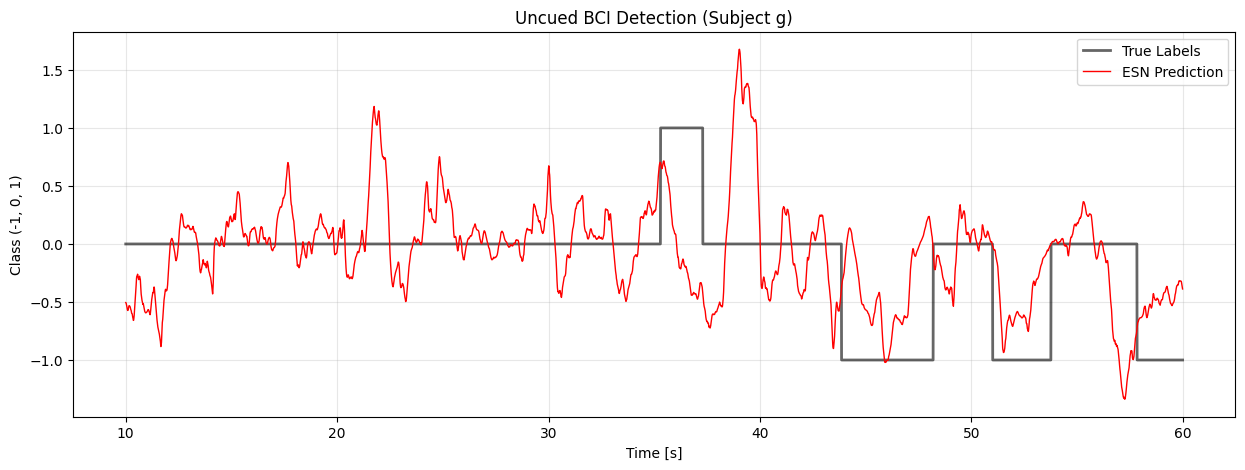

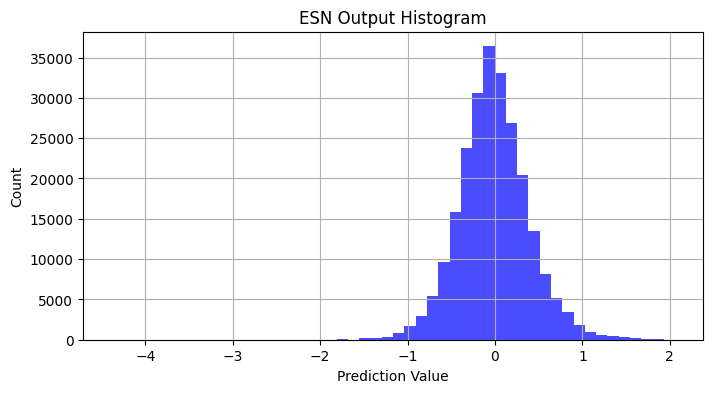

In [11]:
plt.figure(figsize=(15, 5))
samples_to_show = 5000 
start_sample = 1000

t = np.arange(start_sample, start_sample + samples_to_show) / fs

plt.plot(t, y_test[start_sample:start_sample+samples_to_show], 'k-', label='True Labels', linewidth=2, alpha=0.6)
plt.plot(t, y_pred_continuous[start_sample:start_sample+samples_to_show], 'r-', label='ESN Prediction', linewidth=1)

plt.title(f'Uncued BCI Detection (Subject {subject})')
plt.xlabel('Time [s]')
plt.ylabel('Class (-1, 0, 1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(y_pred_continuous, bins=50, color='blue', alpha=0.7)
plt.title('ESN Output Histogram')
plt.xlabel('Prediction Value')
plt.ylabel('Count')
plt.grid(True)
plt.show()